In [1]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_dual_results(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    max_size1 = 0
    for i in range(20):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    for i in range(20,40):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size1):
            max_size1 = th[0]

    print("CCEH0 max runtime = ",max_size0, "CCEH1 max runtime = ", max_size1)
    
    MAX_SIZE = min(max_size0, max_size1)

    cceh0 = np.zeros(max_size0)
    cceh1 = np.zeros(max_size1)
    
    for i in range(20):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    cceh0_Mops = cceh0[:MAX_SIZE]/1024/1024
    time_x = np.array([i for i in np.arange(0.5, (MAX_SIZE + 1)/2, 0.5)])
    through_x = cceh0_Mops
    print("Through0: ", sum(through_x), "/", time_x[-1], sum(through_x)/time_x[-1])

    for i in range(20, 40):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]

        padding = np.pad(eopch, (0,max_size1-cur_length), 'constant', constant_values=(0,0))
        cceh1 += padding
    cceh1_Mops = cceh1[:MAX_SIZE]/1014/1024
    time_y = np.array([i for i in np.arange(0.5, (MAX_SIZE + 1)/2, 0.5)])
    through_y = cceh1_Mops
    print("Through1: ", sum(through_y), "/", time_y[-1], sum(through_y)/time_y[-1])
    
    print("Overall throughput = ", (sum(through_x) + sum(through_y))/ (MAX_SIZE/2) )
    return time_x, through_x, time_y, through_y

In [30]:
# time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_multi/cceh2_dynamic_g1.txt")
time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_bufferdist/ccehdual2_g5.txt")
time_f0, through_f0, time_f1, through_f1 = get_dual_results("./results_multi/cceh2_fixed_g5.txt")

print (len(time_d0), len(through_d0), len(time_d1), len(through_d1))


CCEH0 max runtime =  27 CCEH1 max runtime =  13
Through0:  37.63866424560547 / 6.5 5.790563730093149
Through1:  110.74642504930966 / 6.5 17.037911546047642
Overall throughput =  22.82847527614079
CCEH0 max runtime =  30 CCEH1 max runtime =  18
Through0:  47.12200164794922 / 9.0 5.235777960883246
Through1:  113.17820050542406 / 9.0 12.575355611713784
Overall throughput =  17.81113357259703
13 13 13 13


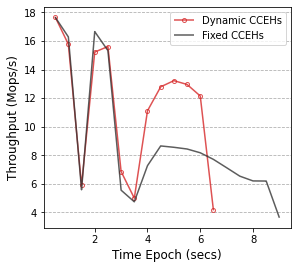

In [31]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Dynamic-CCEH0', 'Dynamic-CCEH1', 'Dynamic CCEHs', 'Fixed-CCEH0', 'Fixed-CCEH1', 'Fixed CCEHs']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True, sharex=True, sharey=True)


if (through_d0.shape[0] > through_d1.shape[0]):
    thr1 = np.pad(through_d1, (0,through_d0.shape[0] - through_d1.shape[0]), 'constant', constant_values=(0,0))
    ax.plot(time_d0, thr1+through_d0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)
else:
    thr0 = np.pad(through_d0, (0,through_d1.shape[0] - through_d0.shape[0]), 'constant', constant_values=(0,0))
    ax.plot(time_d1, thr0+through_d1, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)

if (through_f0.shape[0] > through_f1.shape[0]):
    thrb = np.pad(through_f1, (0,through_f0.shape[0] - through_f1.shape[0]), 'constant', constant_values=(0,0))
    ax.plot(time_f0, thrb+through_f0, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)
else:
    thra = np.pad(through_f0, (0,through_f1.shape[0] - through_f0.shape[0]), 'constant', constant_values=(0,0))
    ax.plot(time_f1, thra+through_f1, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

fig.savefig("results_multi/cmp_g5_onlywritesfactor.pdf", bbox_inches='tight', pad_inches=0)

## Buffered CCEH with Different Write Ratio

CCEH0 max runtime =  54
54


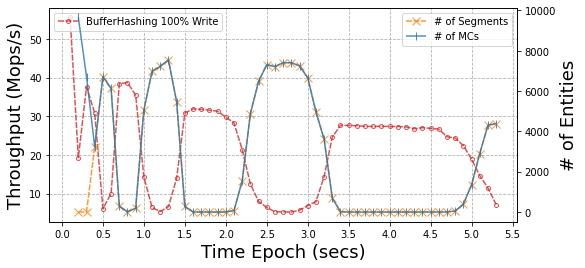

In [84]:
# Plot throughput from a single DIMM

"""
Calculate throughput : (epoch_ops/epoch_time)
"""
import pandas as pd
import numpy as np

def get_single_result(path):
    buffer_dist = []
    statistic = []
    segments = []
    mc = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            elif (line.startswith("[SN]")):
                segments.append(line.strip("[SN]").strip("\n"))
            elif (line.startswith("[MC]")):
                mc.append(line.strip("[MC]").strip("\n"))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (segments):
        segments = np.array(segments)
        segments = pd.DataFrame(segments, columns=['segnum'], dtype=np.float)
    if (mc):
        mc = np.array(mc)
        mc = pd.DataFrame(mc, columns=['mc'], dtype=np.float)

    
#     segments = pd.DataFrame(segments, columns=['segnum'], dtype=np.float)
#     mc = pd.DataFrame(mc, columns=['mc'], dtype=np.float)

    segments = segments-segments.shift(1)
    mc = mc-mc.shift(1)
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    for i in range(16):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    print("CCEH0 max runtime = ",max_size0)

    cceh0 = np.zeros(max_size0)
    NumberOfSegments = np.zeros(max_size0)
    NumberOfMCs = np.zeros(max_size0)
    for i in range(16):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    
    epoch_time = 0.1
    thread = 16
    cceh0_Mops = cceh0/epoch_time/1024/1024
    max_time = statistic['time'].max()
#     time_x = np.array([i for i in np.arange(0.5, (max_size0 + 1)/2, 0.5)])
    time_x = np.array([i for i in np.arange(epoch_time, (max_time), epoch_time)])
    print(len(time_x))
    through_x = cceh0_Mops

    return time_x, through_x, segments, mc

# time_g0, through_g0 = get_single_result("results_multi/cceh_buflog_g0.txt")
# time_g1, through_g1 = get_single_result("results_multi/cceh_buflog_g1.txt")
# time_g2, through_g2 = get_single_result("results_multi/cceh_buflog_g2.txt")
# time_g3, through_g3 = get_single_result("results_multi/cceh_buflog_g3.txt")
# time_g4, through_g4 = get_single_result("results_multi/cceh_buflog_g4.txt")
# time_g5, through_g5 = get_single_result("results_multi/cceh_buflog_g5.txt")
time, through, seg, mc = get_single_result("results_multi/newtest.txt")


import matplotlib.pyplot as plt
import sys
import math
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['#FF7F0E', '#2077B4', '#D62728', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

# label = ['Buffered-CCEH 100% Write', 'Buffered-CCEH 80%   Write', 'Buffered-CCEH 60%   Write', 'Buffered-CCEH 40%   Write', 'Buffered-CCEH 20%   Write', 'Buffered-CCEH 0%     Write']
label = ['BufferHashing 100% Write', '# of Segments', '# of MCs', 'Buffered-CCEH 40%   Write', 'Buffered-CCEH 20%   Write', 'Buffered-CCEH 0%     Write']

fig, ax = plt.subplots(figsize=(8, 3.6), constrained_layout=True, sharex=True, sharey=True)

ax1 = ax.twinx()

ax.plot(time[:-1], through[:-1], color=colors[2], marker=markers[2], dashes=dashes[1], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax1.plot(time[:-1], seg['segnum'].values, color=colors[3], marker=markers[0], dashes=dashes[1], label = label[1], alpha=0.8, fillstyle='none', markersize=8)
ax1.plot(time[:-1], mc['mc'].values, color=colors[4], marker=markers[1], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)


ax.legend(loc="upper left")
ax1.legend(loc="upper right")

ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')
ax.xaxis.grid(True, which='both')

# ax.set_title('Time Epoch(1 secs) Throughput \n CCEH0 0% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=18)
ax.set_xticks(np.arange(0, 6, 0.5))

# ax.set_ylim([0.0001, 50])
ax.set_ylabel('Throughput (Mops/s)', fontsize=18)
ax1.set_ylabel('# of Entities', fontsize=18)
# if (saveimg):
fig.savefig("./BufferHashing_Writes.pdf", bbox_inches='tight', pad_inches=0)

In [85]:
# Plot throughput from a single DIMM

"""
Calculate throughput : (epoch_ops/epoch_time)
"""
import pandas as pd
import numpy as np

def get_single_result(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    print(statistic)
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """

    cceh0 = []
    for i in range(1000000, int(120000000/8)+1, 1000000):
#         print(i)
        epoch = statistic[statistic["cur_done"]==i]
#         print(epoch)
        seg_time = epoch['seg_time'].values
        max_seg_time = max(seg_time)
        cceh0.append(8*1000000/max_seg_time/1024/1024)
    cceh0_Mops = cceh0
#     print(cceh0_Mops)
    time_x = np.array([i/1000000 for i in np.arange(1000000*8, 120000001, 1000000*8)])
#     print(time_x)
    through_x = cceh0_Mops

    return time_x[:-1], through_x[:-1]

# time_g0, through_g0 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_10000.txt")
# time_g1, through_g1 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_30000.txt")
# time_g2, through_g2 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_50000.txt")
# time_g3, through_g3 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_70000.txt")
# time_g4, through_g4 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_90000.txt")
# time_g5, through_g5 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_110000.txt")
# time_g6, through_g6 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_130000.txt")
# time_g7, through_g7 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_150000.txt")
# time_g8, through_g8 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_170000.txt")
# time_g9, through_g9 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_190000.txt")
# time_g10, through_g10 = get_single_result("results_diffbuf/batch_cceh_fixed_g0_210000.txt")

time_g0, through_g0 = get_single_result("results_diffbuf/cceh_fixed_g0_10000.txt")
time_g1, through_g1 = get_single_result("results_diffbuf/cceh_fixed_g0_30000.txt")
time_g2, through_g2 = get_single_result("results_diffbuf/cceh_fixed_g0_50000.txt")
time_g3, through_g3 = get_single_result("results_diffbuf/cceh_fixed_g0_70000.txt")
time_g4, through_g4 = get_single_result("results_diffbuf/cceh_fixed_g0_90000.txt")
time_g5, through_g5 = get_single_result("results_diffbuf/cceh_fixed_g0_110000.txt")
time_g6, through_g6 = get_single_result("results_diffbuf/cceh_fixed_g0_130000.txt")
time_g7, through_g7 = get_single_result("results_diffbuf/cceh_fixed_g0_150000.txt")
time_g8, through_g8 = get_single_result("results_diffbuf/cceh_fixed_g0_170000.txt")
time_g9, through_g9 = get_single_result("results_diffbuf/cceh_fixed_g0_190000.txt")
time_g10, through_g10 = get_single_result("results_diffbuf/cceh_fixed_g0_210000.txt")



import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['10000 Buffers', '30000 Buffers', '50000 Buffers', '70000 Buffers', '90000 Buffers', '110000 Buffers', '130000 Buffers', '150000 Buffers', '170000 Buffers', '190000 Buffers', '210000 Buffers']
label = ['10K Buffers', '30K Buffers', '50K Buffers', '70K Buffers', '90K Buffers', '110K Buffers', '130K Buffers', '150K Buffers', '170K Buffers', '190K Buffers', '210K Buffers']

fig, ax = plt.subplots(figsize=(8, 3.6))

# ax.plot(time_g0, through_g0, color=colors[0], marker=markers[0], dashes=dashes[0], label = label[0], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g1, through_g1, color=colors[0], marker=markers[0], dashes=dashes[0], label = label[1], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g2, through_g2, color=colors[3], marker=markers[0], dashes=dashes[0], label = label[2], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g3, through_g3, color=colors[1], marker=markers[0], dashes=dashes[0], label = label[3], alpha=0.8, fillstyle='none', markersize=4)
# ax.plot(time_g4, through_g4, color=colors[4], marker=markers[0], dashes=dashes[0], label = label[4], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g5, through_g5, color=colors[2], marker=markers[0], dashes=dashes[0], label = label[5], alpha=0.8, fillstyle='none', markersize=4)
# ax.plot(time_g6, through_g6, color=colors[6], marker=markers[0], dashes=dashes[0], label = label[6], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g7, through_g7, color=colors[5], marker=markers[0], dashes=dashes[0], label = label[7], alpha=0.8, fillstyle='none', markersize=4)
# ax.plot(time_g8, through_g8, color=colors[8], marker=markers[0], dashes=dashes[0], label = label[8], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g9, through_g9, color=colors[4], marker=markers[0], dashes=dashes[0], label = label[9], alpha=0.8, fillstyle='none', markersize=4)
# ax.plot(time_g10, through_g10, color=colors[10], marker=markers[0], dashes=dashes[0], label = label[10], alpha=0.8, fillstyle='none', markersize=4)

ax.legend(loc="upper right")

ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax.set_title('Time Epoch(1 secs) Throughput \n CCEH0 0% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (Mops)', fontsize=12)

# ax.set_ylim([0.0001, 50])
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)
# if (saveimg):
fig.savefig("./throughput_diffbuf_ops.pdf", bbox_inches='tight', pad_inches=0)

      thread  last_done   cur_done  seg_time     time
0       21.0        0.0   483000.0    0.5000   0.5000
1       26.0        0.0   446000.0    0.5000   0.5000
2        6.0        0.0   493000.0    0.5000   0.5000
3       37.0        0.0   469000.0    0.5003   0.5003
4       33.0        0.0   492000.0    0.5002   0.5002
...      ...        ...        ...       ...      ...
1597    11.0  5814000.0  5909000.0    0.5072  20.0082
1598    37.0  5777000.0  5878000.0    0.4978  20.0149
1599    31.0  5792000.0  5891000.0    0.5113  20.0133
1600     5.0  5846000.0  5975000.0    0.4994  20.5010
1601    22.0  5811000.0  5943000.0    0.4945  20.5000

[1602 rows x 5 columns]


ValueError: max() arg is an empty sequence

C:\Users\Chen.000\AppData\Local\Temp/ipykernel_10980/2024439533.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
C:\Users\Chen.000\AppData\Local\Temp/ipykernel_10980/2024439533.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

     thread   last_done    cur_done  seg_time     time
0       7.0         0.0   1000000.0    0.3630   0.3630
1       1.0         0.0   1000000.0    0.3660   0.3660
2       3.0         0.0   1000000.0    0.3666   0.3666
3       4.0         0.0   1000000.0    0.3729   0.3729
4       0.0         0.0   1000000.0    0.3750   0.3750
..      ...         ...         ...       ...      ...
115     0.0  14000000.0  15000000.0    1.3318  12.6873
116     5.0  14000000.0  15000000.0    1.3169  12.6995
117     4.0  14000000.0  15000000.0    1.3174  12.7173
118     2.0  14000000.0  15000000.0    1.3255  12.7260
119     6.0  14000000.0  15000000.0    1.2915  12.8167

[120 rows x 5 columns]
[  8.  16.  24.  32.  40.  48.  56.  64.  72.  80.  88.  96. 104. 112.] [18.361960364019254, 16.243122272195016, 16.69817144068724, 8.741286126546745, 11.669309469639032, 15.015537357311553, 14.300645794283037, 5.578673977222873, 6.119180727662817, 8.22664926811516, 8.041946380573416, 7.596728598277408, 6.790738345

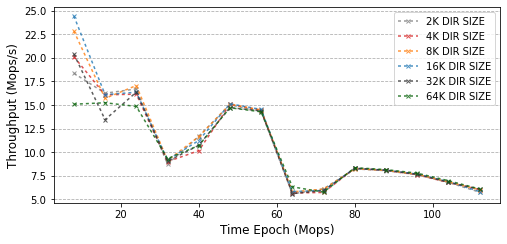

In [49]:
# Plot throughput from a single DIMM

"""
Calculate throughput : (epoch_ops/epoch_time)
"""
import pandas as pd
import numpy as np

def get_single_result(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    print(statistic)
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """

    cceh0 = []
    for i in range(1000000, int(120000000/8)+1, 1000000):
#         print(i)
        epoch = statistic[statistic["cur_done"]==i]
#         print(epoch)
        seg_time = epoch['seg_time'].values
        max_seg_time = max(seg_time)
        cceh0.append(8*1000000/max_seg_time/1024/1024)
    cceh0_Mops = cceh0
#     print(cceh0_Mops)
    time_x = np.array([i/1000000 for i in np.arange(1000000*8, 120000001, 1000000*8)])
#     print(time_x)
    through_x = cceh0_Mops

    return time_x[:-1], through_x[:-1]

time_g1, through_g1 = get_single_result("results_dirsize/batch_cceh_fixed_g0_dir2.txt")
print(time_g1, through_g1)
time_g2, through_g2 = get_single_result("results_dirsize/batch_cceh_fixed_g0_dir4.txt")
time_g3, through_g3 = get_single_result("results_dirsize/batch_cceh_fixed_g0_dir8.txt")
time_g4, through_g4 = get_single_result("results_dirsize/batch_cceh_fixed_g0_dir16.txt")
time_g5, through_g5 = get_single_result("results_dirsize/batch_cceh_fixed_g0_dir32.txt")
time_g6, through_g6 = get_single_result("results_dirsize/batch_cceh_fixed_g0_dir64.txt")



import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['2K DIR SIZE', '4K DIR SIZE', '8K DIR SIZE', '16K DIR SIZE', '32K DIR SIZE', '64K DIR SIZE']

fig, ax = plt.subplots(figsize=(8, 3.6))

ax.plot(time_g1, through_g1, color=colors[0], marker=markers[0], dashes=dashes[0], label = label[0], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g2, through_g2, color=colors[3], marker=markers[0], dashes=dashes[0], label = label[1], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g3, through_g3, color=colors[1], marker=markers[0], dashes=dashes[0], label = label[2], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g4, through_g4, color=colors[2], marker=markers[0], dashes=dashes[0], label = label[3], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g5, through_g5, color=colors[5], marker=markers[0], dashes=dashes[0], label = label[4], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g6, through_g6, color=colors[4], marker=markers[0], dashes=dashes[0], label = label[5], alpha=0.8, fillstyle='none', markersize=4)

ax.legend(loc="upper right")

ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax.set_title('Time Epoch(1 secs) Throughput \n CCEH0 0% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (Mops)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)
# if (saveimg):
fig.savefig("./throughput_dirsize_ops.pdf", bbox_inches='tight', pad_inches=0)

C:\Users\Chen.000\AppData\Local\Temp/ipykernel_10980/3036957879.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
C:\Users\Chen.000\AppData\Local\Temp/ipykernel_10980/3036957879.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

     thread   last_done    cur_done  seg_time     time
0       7.0         0.0   1000000.0    1.0185   1.0185
1       0.0         0.0   1000000.0    1.0208   1.0208
2       3.0         0.0   1000000.0    1.0216   1.0216
3       5.0         0.0   1000000.0    1.0225   1.0225
4       1.0         0.0   1000000.0    1.0249   1.0249
..      ...         ...         ...       ...      ...
115     5.0  14000000.0  15000000.0    1.1774  16.4580
116     6.0  14000000.0  15000000.0    1.1657  16.5114
117     1.0  14000000.0  15000000.0    1.1671  16.5162
118     2.0  14000000.0  15000000.0    1.1615  16.5209
119     4.0  14000000.0  15000000.0    1.1503  16.5678

[120 rows x 5 columns]
     thread   last_done    cur_done  seg_time     time
0       2.0         0.0   1000000.0    1.0236   1.0236
1       7.0         0.0   1000000.0    1.0243   1.0243
2       3.0         0.0   1000000.0    1.0243   1.0243
3       5.0         0.0   1000000.0    1.0253   1.0253
4       0.0         0.0   1000000.0    1.

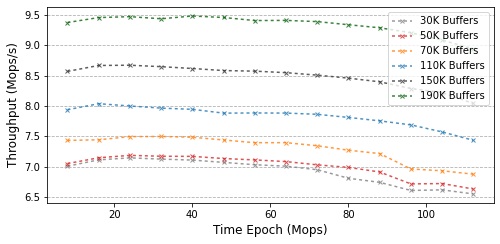

In [112]:
# Plot throughput from a single DIMM

"""
Calculate throughput : (epoch_ops/epoch_time)
"""
import pandas as pd
import numpy as np

def get_single_result(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    print(statistic)
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """

    cceh0 = []
    for i in range(1000000, int(120000000/8)+1, 1000000):
#         print(i)
        epoch = statistic[statistic["cur_done"]==i]
#         print(epoch)
        seg_time = epoch['seg_time'].values
        max_seg_time = max(seg_time)
        cceh0.append(8*1000000/max_seg_time/1024/1024)
    cceh0_Mops = cceh0
#     print(cceh0_Mops)
    time_x = np.array([i/1000000 for i in np.arange(1000000*8, 120000001, 1000000*8)])
#     print(time_x)
    through_x = cceh0_Mops

    return time_x[:-1], through_x[:-1]

time_g1, through_g1 = get_single_result("results_bufferrate/batch_cceh_fixed_g0_bufferrate30000.txt")
time_g2, through_g2 = get_single_result("results_bufferrate/batch_cceh_fixed_g0_bufferrate50000.txt")
time_g3, through_g3 = get_single_result("results_bufferrate/batch_cceh_fixed_g0_bufferrate70000.txt")
time_g4, through_g4 = get_single_result("results_bufferrate/batch_cceh_fixed_g0_bufferrate110000.txt")
time_g5, through_g5 = get_single_result("results_bufferrate/batch_cceh_fixed_g0_bufferrate150000.txt")
time_g6, through_g6 = get_single_result("results_bufferrate/batch_cceh_fixed_g0_bufferrate190000.txt")



import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['30K Buffers', '50K Buffers', '70K Buffers', '110K Buffers', '150K Buffers', '190K Buffers']

fig, ax = plt.subplots(figsize=(8, 3.6))

ax.plot(time_g1, through_g1, color=colors[0], marker=markers[0], dashes=dashes[0], label = label[0], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g2, through_g2, color=colors[3], marker=markers[0], dashes=dashes[0], label = label[1], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g3, through_g3, color=colors[1], marker=markers[0], dashes=dashes[0], label = label[2], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g4, through_g4, color=colors[2], marker=markers[0], dashes=dashes[0], label = label[3], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g5, through_g5, color=colors[5], marker=markers[0], dashes=dashes[0], label = label[4], alpha=0.8, fillstyle='none', markersize=4)
ax.plot(time_g6, through_g6, color=colors[4], marker=markers[0], dashes=dashes[0], label = label[5], alpha=0.8, fillstyle='none', markersize=4)

ax.legend(loc="upper right")

ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax.set_title('Time Epoch(1 secs) Throughput \n CCEH0 0% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (Mops)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)
# if (saveimg):
fig.savefig("./throughput_bufferrate.pdf", bbox_inches='tight', pad_inches=0)

C:\Users\Chen.000\AppData\Local\Temp/ipykernel_17248/1068152521.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
C:\Users\Chen.000\AppData\Local\Temp/ipykernel_17248/1068152521.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

7      1.00
15     1.00
23     1.00
31     1.00
39     1.00
47     1.00
55     1.00
63     0.60
71     0.53
79     0.53
87     0.53
95     0.52
103    0.49
111    0.42
119    0.37
Name: bufferrate, dtype: float64
[  8.  16.  24.  32.  40.  48.  56.  64.  72.  80.  88.  96. 104. 112.]


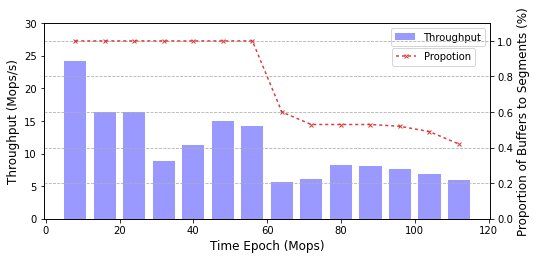

In [2]:
# Plot throughput from a single DIMM

"""
Calculate throughput : (epoch_ops/epoch_time)
"""
import pandas as pd
import numpy as np

def get_single_result(path):
    buffer_dist = []
    statistic = []
    bufferrate = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            if (line.startswith("[bufferrate]")):
                bufferrate.append(line.strip('[bufferrate]').strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    if (bufferrate):
        bufferrate = np.array(bufferrate)
        bufferrate = pd.DataFrame(bufferrate, columns=['#ofbuffers', '#ofsegments', 'bufferrate'], dtype=np.float)
        
    print(bufferrate['bufferrate'][7::8])
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """

    cceh0 = []
    for i in range(1000000, int(120000000/8)+1, 1000000):
#         print(i)
        epoch = statistic[statistic["cur_done"]==i]
#         print(epoch)
        seg_time = epoch['seg_time'].values
        max_seg_time = max(seg_time)
        cceh0.append(8*1000000/max_seg_time/1024/1024)
    cceh0_Mops = cceh0
#     print(cceh0_Mops)
    time_x = np.array([i/1000000 for i in np.arange(1000000*8, 120000001, 1000000*8)])
#     print(time_x)
    through_x = cceh0_Mops

    return time_x[:-1], through_x[:-1], bufferrate

time_g1, through_g1, bufferrate = get_single_result("results_bufferrate/bufferrate_change.txt")


import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['70K Buffers', '50K Buffers', '70K Buffers', '110K Buffers', '150K Buffers', '190K Buffers']

fig = plt.figure(figsize=(8, 3.6))

ax1 = fig.add_subplot(111)
bar_width = 6
opacity = 0.4
error_config = {'ecolor': '0.5'}
ax1.bar(time_g1, through_g1, bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config,
                 label = 'Throughput')
ax1.set_ylim([0,30])
ax1.legend(loc="best")
# ax1.grid(which='major', linestyle='--', zorder=0)
# ax1.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax1.xaxis.grid(False, which='both')

# ax.set_title('Time Epoch(1 secs) Throughput \n CCEH0 0% Write', fontsize = 14)
ax1.set_xlabel('Time Epoch (Mops)', fontsize=12)
ax1.set_ylabel('Throughput (Mops/s)', fontsize=12)

ax2 = ax1.twinx()
print(time_g1)
ax2.plot(time_g1, bufferrate['bufferrate'][7:-1:8].values, color=colors[3], marker=markers[0], dashes=dashes[0], label = 'Propotion', alpha=0.89, fillstyle='none', markersize=4)
ax2.legend(loc="best",  bbox_to_anchor=(0.977, 0.9))
ax2.grid(which='major', linestyle='--', zorder=0)
ax2.grid(which='minor', linestyle='--', zorder=0, linewidth=0.8)
ax2.set_ylabel('Proportion of Buffers to Segments (%)', fontsize=12)
ax2.set_ylim([0,1.1])

fig.savefig("./throughput_bufferrate1.pdf", bbox_inches='tight', pad_inches=0)

6000


Text(0, 0.5, '# of Buffers (x$10^3$)')

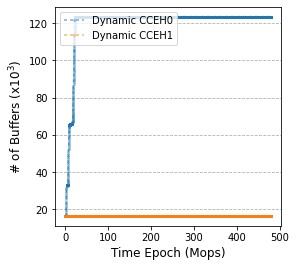

In [68]:
# Plot throughput from a single DIMM

"""
Calculate throughput : (epoch_ops/epoch_time)
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gloyend = None

def get_single_result(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            elif (line.startswith("[Number of Buffers]")):
                buffer_dist.append(line.strip("[Number of Buffers]").strip("\n").split(","))
            else:
                pass
                
    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (buffer_dist):
        buffer_dist = np.array(buffer_dist)
        buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1'], dtype=np.float)
#     buffer_dist = buffer_dist[::2]
    print(len(buffer_dist))
    index = [i*80000/1000000 for i in range(len(buffer_dist))]

    return index, buffer_dist['cceh0'].values, buffer_dist['cceh1'].values

# index, cceh0b, cceh1b = get_single_result("results_bufferdist/bufferdist_p5_g4.txt")
# index, cceh0b, cceh1b = get_single_result("results_bufferdist/ccehdual2_g5_16th.txt")
index, cceh0b, cceh1b = get_single_result("results_multi/testlog1.txt")

import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Dynamic CCEH0', 'Dynamic CCEH1']

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True,)

ax.plot(index, cceh0b/1000, color=colors[2], marker=markers[0], dashes=dashes[0], label = label[0], alpha=0.6, fillstyle='none', markersize=2)
ax.plot(index, cceh1b/1000, color=colors[7], marker=markers[0], dashes=dashes[0], label = label[1], alpha=0.6, fillstyle='none', markersize=2)

# ax.legend(loc="lower right")
ax.legend(loc="upper left")

ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax.set_title('Time Epoch(1 secs) Throughput \n CCEH0 0% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (Mops)', fontsize=12)
ax.set_ylabel('# of Buffers (x%s)' % r'$10^3$', fontsize=12)
# if (saveimg):
# fig.savefig("./results_bufferdist/bufferdist_g5_th16.pdf", bbox_inches='tight', pad_inches=0)

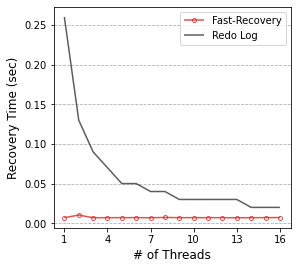

In [12]:
import matplotlib.pyplot as plt
import sys
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Redo Log', 'Fast-Recovery']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True, sharex=True, sharey=True)

t = [i for i in range(1,17)]
r1 = [0.007015, 0.010317, 0.006994, 0.007034, 0.007095,0.0071,0.006954,0.007373,0.00706,0.0071,0.00706,0.00706,0.006939,0.007036,0.007136,0.00718]


r2 = [0.252224,0.160797,0.140294]
r2_ = [0.1435,0.15822,0.16844,0.176879,0.169593,0.17966,0.1894,0.17896,0.18436,0.192939,0.190566,0.201136,0.206696]
r22 = r2+[0.140294-(i - 0.140294)  for i in r2_]

r3 = [0.26,0.13,0.09,0.07,0.05,0.05,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02]
ax.plot(t, r1, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(t, r3, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[0], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')
ax.set_xticks(np.arange(1, 17, 3))

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('# of Threads', fontsize=12)
ax.set_ylabel('Recovery Time (sec)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

fig.savefig("recovery.pdf", bbox_inches='tight', pad_inches=0)